## 머신러닝 모델 평가
* 일반적으로 머신러닝 분석은 <br>
`데이터 가공/변환(전처리) => 모델 학습/예측 => 평가`의 과정을 거침
* 앞의 타이타닉예제에서 모델 평가는 '정확도'만 사용했었음

#### 정확도의 함정
* 앞의 타이타닉 생존자 ML예제의 정확도는 평균 0.77이었음
* 그런데, 정확도 지표만으로 ML모델의 성능을 파악하기에는 다소 문제가 있음 - 왜곡의 위험
* 즉, 탐색적 분석을 시행했을때 성별을 기준으로 생존비율은 여성일때가 더 높았음
* 따라서, 굳이 ML알고리즘을 적용하지 않아도 성별이 여성인 경우 생존, 남성인 경우 사망이라고 예측해도 크게 무리 없음

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
titanic = sns.load_dataset('titanic')

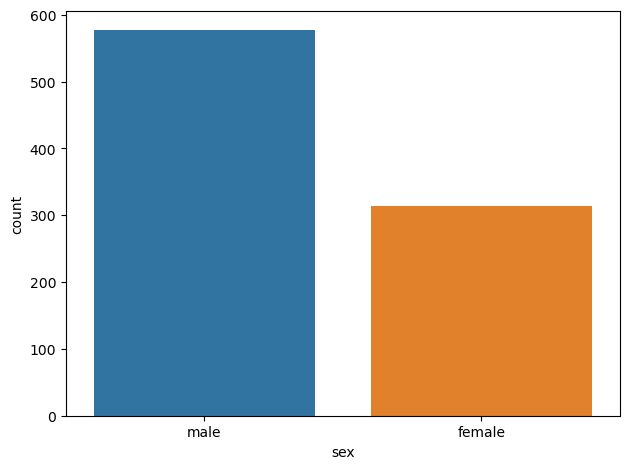

In [3]:
# 남성/여성 비율 확인
sns.countplot(x='sex', data=titanic)
plt.tight_layout()

In [4]:
titanic.groupby(['sex', 'alive'])['alive'].count()

sex     alive
female  no        81
        yes      233
male    no       468
        yes      109
Name: alive, dtype: int64

#### 가짜 분류기 생성
* 성별이 남자면 사망
* 성별이 여자면 생존이라고 예측하는 더미분류기 생성

In [5]:
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # 아무것도 학습하지 않는 fit 메서드 정의
    def fit(self, X, y=None):
        pass

    # 성별이 1(남성)이면 0(사망), 0이면 1
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        # 입력데이터 크기만큼 0으로 채워진 1차원 행렬 생성

        for i in range(X.shape[0]):
            if X['gender'].iloc[i] != 1:
                pred[i] = 1
            # 성별이 여성인 경우 1로 설정

        return pred

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [7]:
titanic = pd.read_csv('titanic3.csv')
data = titanic.iloc[:, :8]
target = titanic.survived

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7, 
                                                    random_state=2309221135, stratify=target)

In [9]:
dyclf = MyDummyClassifier()

dyclf.fit(X_train, y_train)
pred = dyclf.predict(X_test)
accuracy_score(y_test, pred)

0.7806122448979592

In [10]:
# 따라서, 정확도 평가 지표는
# 불균형한 레이블 데이터집합에서의 성능수치로 사용되면 안됨
# => 이러한 한계를 극복하기 위해 오차행렬(confusionmatrix) 사용
# 특히, 정확도보다는 정밀도, 재현율을 더 선호

### 오차행렬
<img src='./img/confusion_matrix.png'>

* confusion matrix
* 학습된 분류모델이 예측을 수행하면서
* `얼마나 헷갈렸는지(confusion)`를 보여주는 지표
* sklearn의 confusion_matrix 함수로 오차행렬 확인 가능
    + TN  FP
    + FN  TP

In [11]:
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
dtclf = DecisionTreeClassifier()

dtclf.fit(X_train, y_train)
pred = dtclf.predict(X_test)
accuracy_score(y_test, pred)

0.7627551020408163

In [13]:
confusion_matrix(y_test, pred)
#     n  p
# f [fn fp]
# t [tn tp]

array([[200,  43],
       [ 50,  99]])

In [14]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       243
           1       0.70      0.66      0.68       149

    accuracy                           0.76       392
   macro avg       0.75      0.74      0.75       392
weighted avg       0.76      0.76      0.76       392



## 정확도accuracy
* 맞는 것(양성, Positive, 1)을 맞다고, 틀린 것(음성, Negative, 0)을 틀리다고 올바르게 예측한 것
* $ accuracy = \frac {TP + TN} {TP + FN + FP + TN} $
* 위 오차행렬 대각선 부분

In [15]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
(tp + tn) / (tp + fn + fp + tn)
# (694+317) / (694+110+178+317)

0.7627551020408163

## 정밀도Precision
* **모델의 예측값**이 얼마나 올바른지 알아봄
* 양성이라고 예측한 것이 얼마나 맞았는지 알아봄 - 스팸분류
* $precision = \frac {TP} {TP+FP}$
* 위 오차행렬 1열 부분

In [16]:
from sklearn.metrics import precision_score

precision_score(y_test, pred)

0.6971830985915493

In [17]:
tp / (tp + fp)
# (317) / (317+110)

0.6971830985915493

## 재현율Recall
* 실제로 맞는 것 중 맞다고 예측된 것들의 비율
* 민감도Sensitivity(통계학), 적중률hit rate(마케팅) - 임상분야
* $recall = \frac {TP} {TP+FN}$
* 위 오차행렬 2행 부분

In [18]:
from sklearn.metrics import recall_score

recall_score(y_test, pred)

0.6644295302013423

In [19]:
tp / (tp+fn)
# (317) / (178+317)

0.6644295302013423

### 특이도Specificity
* 틀린 것 중 틀리다고 예측된 것들의 비율
* (TN) / (TN+FP)
* 위 오차행렬의 1행 부분

In [20]:
recall_score(y_test, pred, pos_label=0)

0.823045267489712

In [21]:
tn / (tn+fp)
(694) / (694+110)

0.8631840796019901

### 간단예제 - 정확도, 정밀도, 재현율(민감도)
* 6마리의 동물형상 중 개p/고양이n를 맞추는 게임을 진행
* <pre>정답 = [개     개     개 고양이 개     고양이]</pre>
* <pre>예측 = [개     고양이 개 고양이 개     개    ]</pre>

In [22]:
# 오차행렬 먼저 그리기
# tp  fn : 3  1
# fp  tn : 1  1

In [23]:
# 정확도 - 개를 개라고, 고양이를 고양이라고 올바르게 예측
(tp + tn) / (tp + fn + fp + tn)

0.7627551020408163

In [24]:
# 정밀도 - 얼마나 개를 잘 예측했나?
# 개라고 예측 - 1 3 5 6
# 실제 개로 판별 - 1 2 3 5
(3) / (3 + 1)

0.75

In [25]:
# 재현율 - 실제 개를 얼마나 잘 찾았는가?
# 실제 개 : 1 2 3 5
# 개라고 적중 : 1 3 5 6

In [26]:
(3) / (3 + 1)

0.75

In [27]:
# 오차행렬대로 나오는 걸 알 수 있음
y_test = ["개", "개", "개", "고양이", "개", "고양이"]
pred = ["개", "고양이", "개", "고양이", "개", "개"]

confusion_matrix(y_test, pred)

array([[3, 1],
       [1, 1]])

In [28]:
accuracy_score(y_test, pred)

0.6666666666666666

In [29]:
precision_score(y_test, pred, pos_label='개')

0.75

In [30]:
recall_score(y_test, pred, pos_label='개')

0.75

### 1종오류/2종오류 알아보기
+ 전자회로기판PCB 생산업체에서 불량률이 6% 이하일때 
+ 계약업체로 선적해서 납품한다는 품질보증계약 체결함
+ 불량률 6%이하 `선적함(P)`, 불량률 6%초과 `선적안함(N)`

In [31]:
# 4000개의 회로판에서 표본 50개 추출
# 4개가 불량 -> 0.08 -> 8% -> 선적x
# 그런데, 4개의 불량이 전체 4000개에서 유일하다면?
# 불량률 0.1% -> 선적취소는 잘못된 결정 (2종오류 - FN)

In [32]:
# 4000개의 회로판에서 표본 50개 추출
# 2개가 불량 -> 0.04 -> 4% -> 선적o
# 그런데, 48개 정상품이 전체 4000개에서 유일
# 불량률 98.8% -> 선적허용은 잘못된 결정 (1종오류 - FP)

### 정밀도/재현율 trade-off
* 분류하는 업무의 특성상 정밀도 또는 재현율이 특별히 강조되어야 하는 경우 존재
     + 정밀도 : 스팸분류 (FP 중시 - 1종오류)
     + 재현율 : 임상실험 (FN 중시 - 2종오류)
* 결정 임계값을 조정하면 정밀도 또는 재현율을 높일 수 있음
     + 즉, 이진분류에서 0 또는 1로 판정할 기준값을 의미
     + 임계값을 0.5로 정하는 경우 기준값보다 확률이 크면 positive, 작으면 negative로 결정
* 한편, 정밀도와 재현율은 상호보완적인 지표이기때문에, 
* 어느 한쪽을 올리면 다른 한쪽은 떨어지는 관계를 뜀